In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle
import threshold
import find_lane_lines as finder
import curvature_measurement as cm
import draw_lane as dl
import warp
import transform_perspective as trp

In [2]:
def show_gray(images):
    for im in images:
        plt.figure()
        plt.imshow(im, cmap='gray')

def show(images):
    for im in images:
        plt.figure()
        plt.imshow(im)

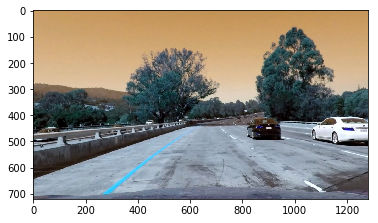

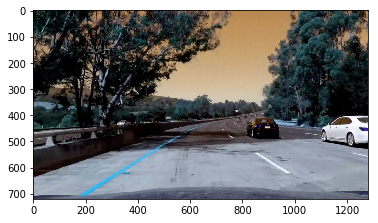

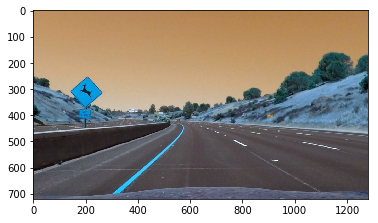

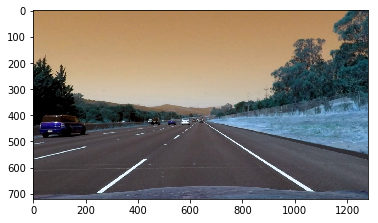

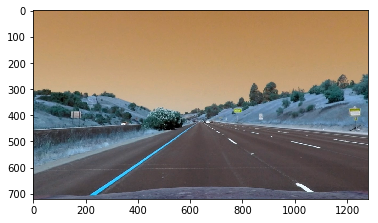

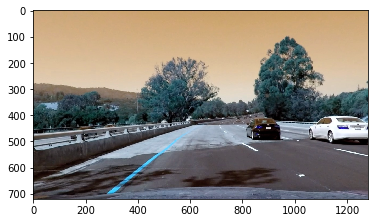

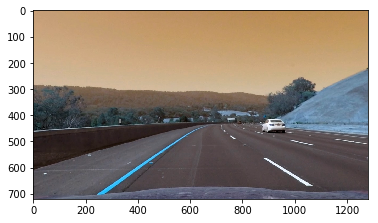

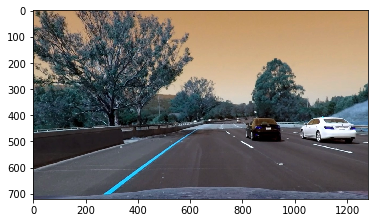

In [3]:
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle[0]
dist = dist_pickle[1]

test_images = glob.glob('test_images/*')
images = []
for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    images.append(dst)
    plt.figure()
    plt.imshow(dst)
plt.show()

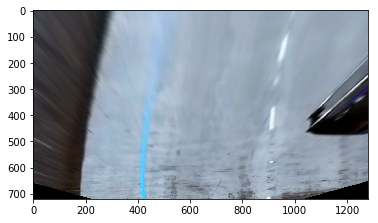

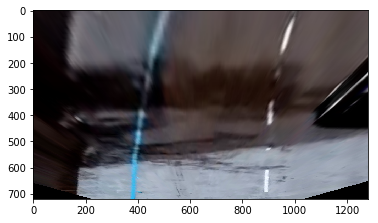

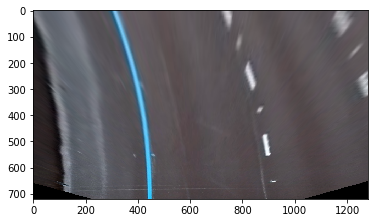

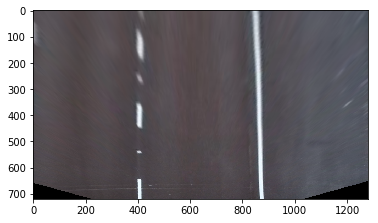

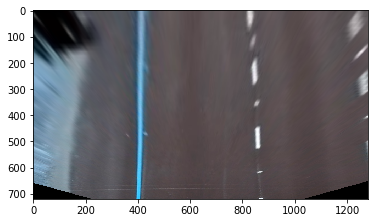

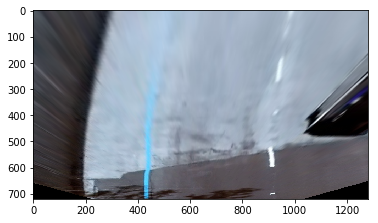

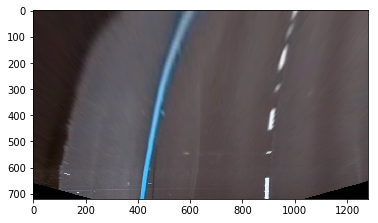

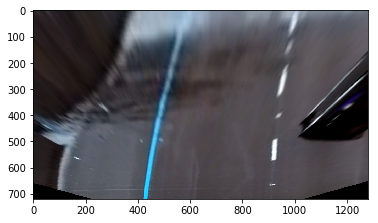

In [7]:
M = pickle.load(open( "perspectiveTransformMatrix.p", "rb" ))
transformed_images = []
for image in images:
    imshape = image.shape
    trf = trp.transform(image, M)
    transformed_images.append(trf)
    show_gray([trf])
plt.show()

In [9]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray=img
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient == 'x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled)
    binary[(scaled <= thresh_max) & (scaled >= thresh_min)] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled)
    binary[(scaled <= mag_thresh[1]) & (scaled >= mag_thresh[0])] = 1
    return binary

'''
Direction of the gradient is computed with arctan(sobely/sobelx)
'''
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(direction)
    binary[(direction <= thresh[1]) & (direction >= thresh[0])] = 1
    return binary

def s_select_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s <= thresh[1]) & (s > thresh[0])] = 1
    return binary_output

def s_select(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    return s

def process_image(image):
    hls = s_select_thresh(image, (170, 255))
    s = s_select(image)
    sobelx = abs_sobel_thresh(s, 'x', 20, 100)
    #sobely = abs_sobel_thresh(s, 'y', 20, 100)
    #sobelxy = mag_thresh(s, 3, (20, 50))
    dr = dir_threshold(s, 3,(0.7, 1.3))
    combined = np.zeros_like(s)
    combined[((dr == 1) & (sobelx == 1)) | (hls == 1)] = 1
    return combined

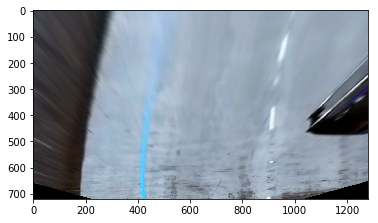

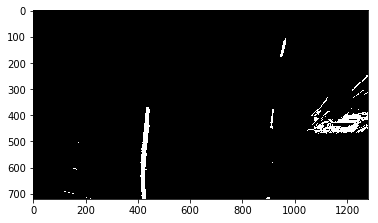

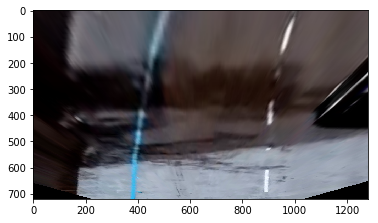

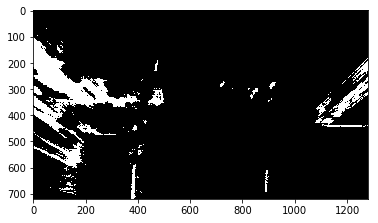

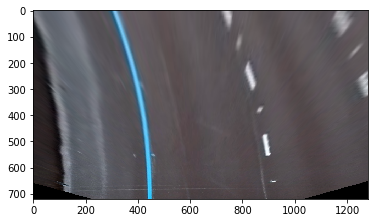

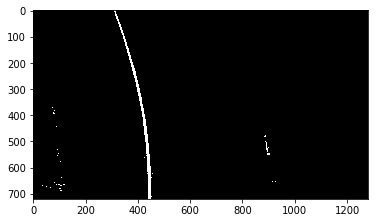

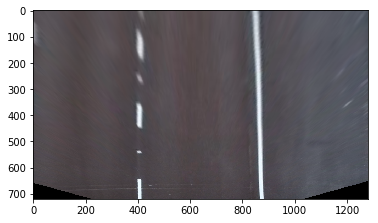

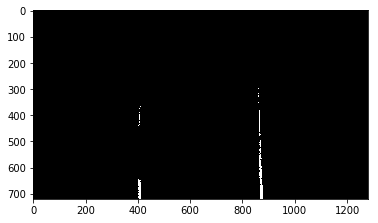

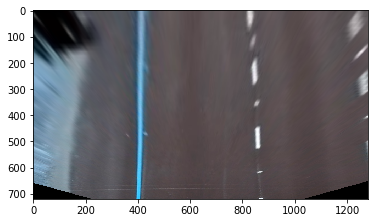

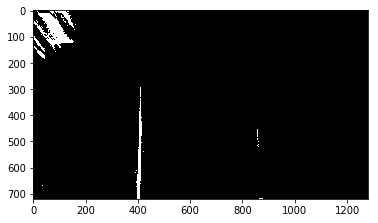

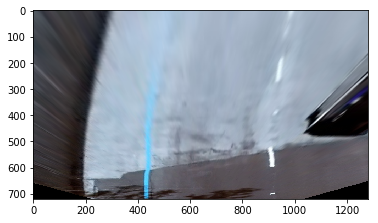

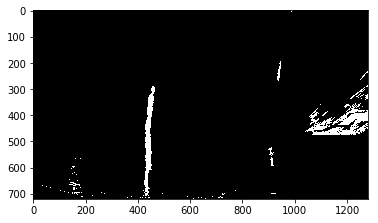

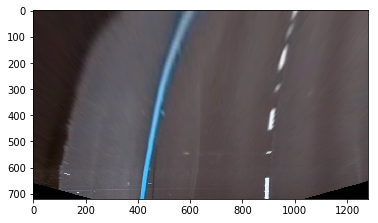

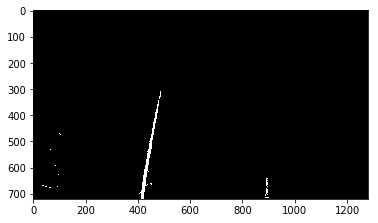

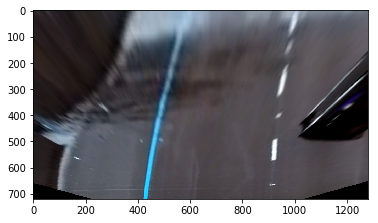

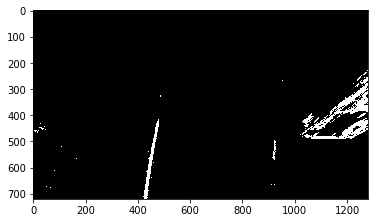

In [12]:
thresholded_images = []
for image in transformed_images:
    thr = process_image(image)
    thresholded_images.append(thr)
    show([image])
    show_gray([thr])
plt.show()

In [ ]:
'''''
    a = (210,imshape[0]-50)
    b = ((imshape[1]/2)-180, 520)
    c = ((imshape[1]/2)+180, 520)
    d = (imshape[1]-210,imshape[0]-50)
    
    a = (190,imshape[0])
    b = ((imshape[1]/2)-35, 440)
    c = ((imshape[1]/2)+35, 440)
    d = (imshape[1]-160,imshape[0])
'''''

#perspective transform
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

transformed_images = []
for i, image in enumerate(images):
    #if i != 3:
    #    continue
    imshape = image.shape
    a = (276,imshape[0]-50)
    b = ((imshape[1]/2)-47, 450)
    c = ((imshape[1]/2)+55, 450)
    d = (imshape[1]-240,imshape[0]-50)
    vertices = np.array([[a, b, c, d]], dtype=np.int32)
    src = np.array([[a, b, c, d]], dtype=np.float32)
    selected = region_of_interest(image, vertices)
    offsetx = 400
    offsety = 0
    dst = np.float32([[offsetx,imshape[0]-offsety], 
                      [offsetx,offsety], 
                      [imshape[1]-offsetx, offsety], 
                      [imshape[1]-offsetx, imshape[0]-offsety]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    a = (350,imshape[0])
    b = (350, 600)
    c = (100,0)
    d = (imshape[1],0)
    e = (1010, 600)
    f = (1010, imshape[0])
    roi_points = np.array([[a, b, c, d, e, f]], dtype=np.int32)
    selected_final = region_of_interest(warped, roi_points)
    transformed_images.append(warped)
    #plt.figure(figsize=(12,12))
    #plt.imshow(images[i])
    #plt.imshow(selected_final, cmap='gray')
    plt.figure(figsize=(12,12))
    plt.imshow(warped, cmap='gray')
    #plt.imshow(selected)
    
plt.show()

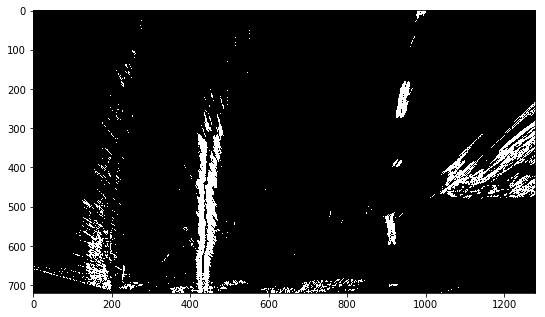

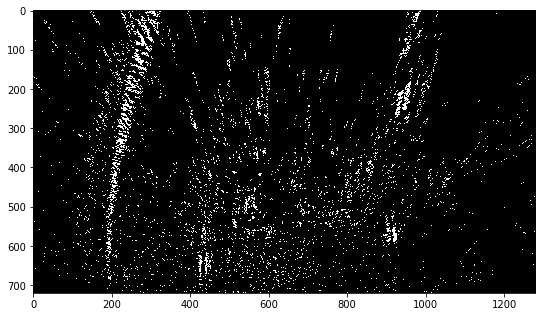

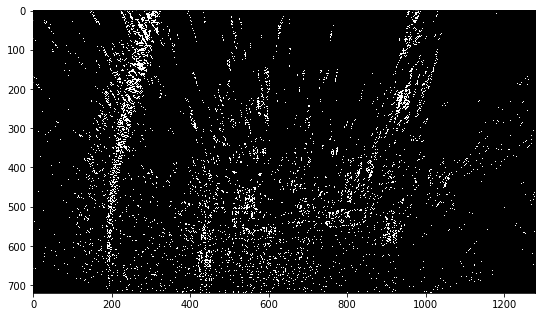

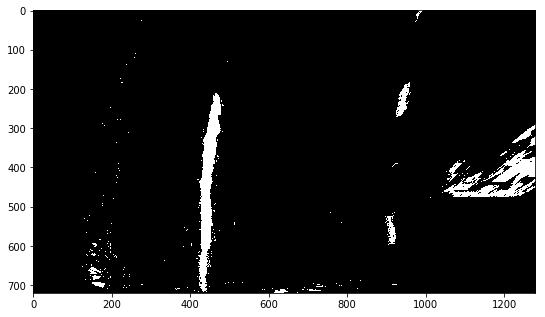

In [105]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import glob
import transform_perspective as trp
t=9
def show_gray(images):
    for im in images:
        plt.figure(figsize=(t,t))
        plt.imshow(im, cmap='gray')

def show(images):
    for im in images:
        plt.figure(figsize=(t,t))
        plt.imshow(im)

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray=img
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient == 'x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled)
    binary[(scaled <= thresh_max) & (scaled >= thresh_min)] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled)
    binary[(scaled <= mag_thresh[1]) & (scaled >= mag_thresh[0])] = 1
    return binary

'''
Direction of the gradient is computed with arctan(sobely/sobelx)
'''
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(direction)
    binary[(direction <= thresh[1]) & (direction >= thresh[0])] = 1
    return binary

def s_select_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s <= thresh[1]) & (s > thresh[0])] = 1
    return binary_output

def s_select(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    return s

def process_image(image):
    hls = s_select_thresh(image, (140, 255))
    s = s_select(image)
    sobelx = abs_sobel_thresh(s, 'x', 7, 140)
    sobely = abs_sobel_thresh(s, 'y', 10, 180)
    show_gray([sobelx])
    sobelxy = mag_thresh(s, 3, (7, 140))
    dr = dir_threshold(image, 3,(0.001, 0.3))
    show_gray([dr])
    dr2 = dir_threshold(image, 3,(0.1, 0.3))
    show_gray([dr2])
    combined = np.zeros_like(s)
    combined[((dr == 1) & (sobelx == 1)) | (hls == 1)] = 1
    #show_gray([sobelx, sobelxy])
    #show([s, hls])
    return combined

dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle[0]
dist = dist_pickle[1]

test_images = glob.glob('test_images/*')
images = []
for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    images.append(dst)

M = pickle.load(open( "perspectiveTransformMatrix.p", "rb" ))
transformed_images = []
for image in images:
    imshape = image.shape
    trf = trp.transform(image, M)
    transformed_images.append(trf)

image = transformed_images[5]
thr = process_image(image)
#show([image])
show_gray([thr])
plt.show()